In [36]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
from dictor import dictor
import seaborn as sns
import matplotlib.pyplot as plt


def extract_experiment_data(json_file):
    variant = Path(json_file).relative_to('./results').parts[0]

    with open(json_file, 'r') as f:
        data = json.load(f)

    data['variant'] = variant
    with open(json_file, 'w') as f:
        json.dump(data, f, indent=4)

    # Extract metadata
    model_family = dictor(data, 'args.model_family')
    peft_method = dictor(data, 'args.peft')
    task = dictor(data, 'args.task')

    eval_runtime = data.get('eval_runtime', 0.0)

    # Get training-specific metrics
    trainable_params = dictor(data, 'train.trainable_params_count', 0.0)
    train_runtime = dictor(data, 'train.train_time', 0.0)

    # Calculate Average GPU Memory (Allocated)
    memory_list = dictor(data, 'train.memory_allocated', [])
    avg_memory = np.mean(memory_list) if memory_list else 0.0

    # Get metrics
    # Some tasks use eval_accuracy, others eval_matthews_correlation
    for key in ['eval_accuracy', 'eval_matthews_correlation', 'eval_pearson', 'eval_spearman',
                'matched_accuracy', 'mismatched_accuracy']:
        if key in data:
            accuracy = data[key]
            yield {
                "Model Family": model_family,
                "PEFT Method": peft_method,
                "Task": task,
                "Variant": variant,
                "Metric Value": round(accuracy, 4),
                "Metric Name": key,
                "Trainable Params (M)": round(trainable_params, 4),
                "Train Runtime (s)": round(train_runtime, 2),
                "Eval Runtime (s)": round(eval_runtime, 2),
                "Avg GPU Memory (MB)": round(avg_memory, 2)
            }


def aggregate_experiment_results(root_dir):
    """
    Finds all .json files under a directory recursively, extracts data,
    and concatenates them into one large DataFrame.
    """
    root_path = Path(root_dir)
    # Recursively find all JSON files
    json_files = list(root_path.rglob("*.json"))

    if not json_files:
        print(f"No JSON files found in {root_dir}")
        return pd.DataFrame()

    all_dfs = []
    for f in json_files:
        print(f"Processing {f}")
        rows = extract_experiment_data(f)
        all_dfs.extend(rows)

    if not all_dfs:
        print("No valid data extracted from found files.")
        return pd.DataFrame()

    # Concatenate all individual DataFrames by row
    final_df = pd.DataFrame.from_records(all_dfs)

    # Sort for better readability
    sort_cols = ["Task", "Model Family", "Variant"]
    final_df = final_df.sort_values(by=[c for c in sort_cols if c in final_df.columns])

    return final_df

df = aggregate_experiment_results('./results/')

Processing results/fft/task_wnli_bert_42/base_32_5e-05_0.01/peft_lora_16_0.05_8/metrics.json
Processing results/fft/task_stsb_bert_42/base_32_5e-05_0.01/peft_lora_16_0.05_8/metrics.json
Processing results/fft/task_qnli_bert_42/base_32_5e-05_0.01/peft_lora_16_0.05_8/metrics.json
Processing results/fft/task_rte_bert_42/base_32_5e-05_0.01/peft_lora_16_0.05_8/metrics.json
Processing results/fft/task_qqp_bert_42/base_32_5e-05_0.01/peft_lora_16_0.05_8/metrics.json
Processing results/fft/task_mrpc_bert_42/base_32_5e-05_0.01/peft_lora_16_0.05_8/metrics.json
Processing results/lora/task_wnli_bert_123/base_32_5e-05_0.01/peft_lora_16_0.05_8/metrics.json
Processing results/lora/task_wnli_bert_42/base_32_5e-05_0.01/peft_lora_16_0.05_8/metrics.json
Processing results/lora/task_mrpc_bert_2024/base_32_5e-05_0.01/peft_lora_16_0.05_8/metrics.json
Processing results/lora/task_qnli_bert_123/base_32_5e-05_0.01/peft_lora_16_0.05_8/metrics.json
Processing results/lora/task_stsb_bert_42/base_32_5e-05_0.01/pef

In [20]:
df

,Model Family,PEFT Method,Task,Variant,Metric Value,Metric Name,Trainable Params (M),Train Runtime (s),Eval Runtime (s),Avg GPU Memory (MB)
16,bert,lora,mnli,lora,0.8213,matched_accuracy,0.2972,1506.50,0.00,463.10
17,bert,lora,mnli,lora,0.8294,mismatched_accuracy,0.2972,1506.50,0.00,463.10
6,bert,lora,mrpc,fft,0.8284,eval_accuracy,109.4838,45.36,0.49,1792.36
9,bert,lora,mrpc,lora,0.7549,eval_accuracy,0.2964,14.93,0.28,463.09
23,bert,lora,mrpc,lora,0.7843,eval_accuracy,0.2964,14.99,0.28,463.09
29,bert,lora,mrpc,lora,0.7819,eval_accuracy,0.2964,15.16,0.28,463.09
3,bert,lora,qnli,fft,0.9054,eval_accuracy,109.4838,1002.44,5.32,1785.11
10,bert,lora,qnli,lora,0.9013,eval_accuracy,0.2964,402.31,3.02,462.30
21,bert,lora,qnli,lora,0.9035,eval_accuracy,0.2964,402.63,2.93,463.09
22,bert,lora,qnli,lora,0.9006,eval_accuracy,0.2964,415.35,3.31,463.09


<Axes: xlabel='Task', ylabel='Metric Value'>

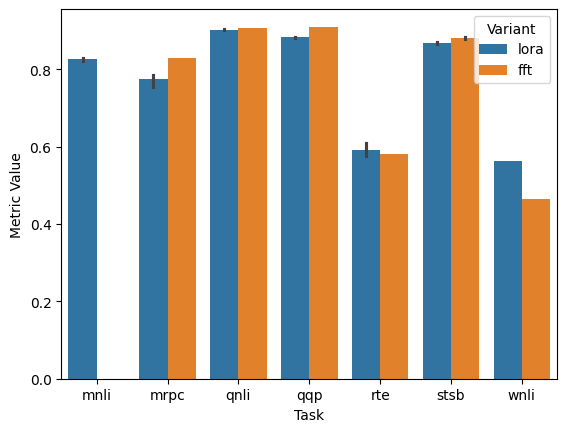

In [22]:
sns.barplot(df, x='Task', y='Metric Value', hue='Variant')

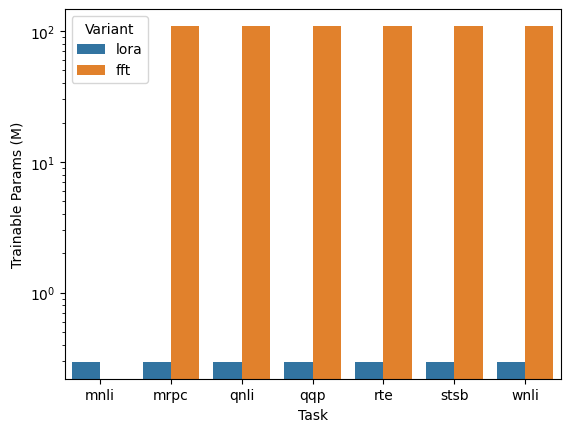

In [25]:
sns.barplot(df, x='Task', y='Trainable Params (M)', hue='Variant')
plt.yscale('log')

<Axes: xlabel='Task', ylabel='Avg GPU Memory (MB)'>

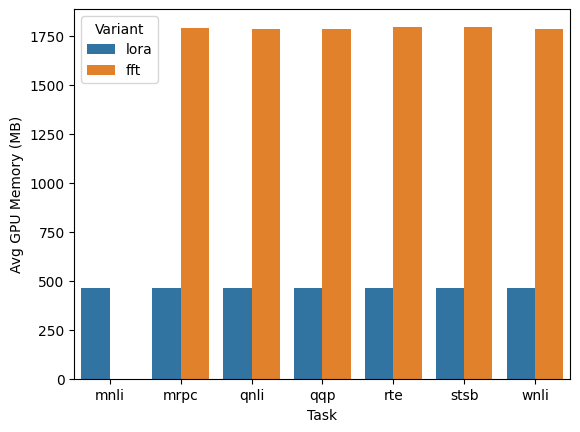

In [27]:
sns.barplot(df, x='Task', y='Avg GPU Memory (MB)', hue='Variant')


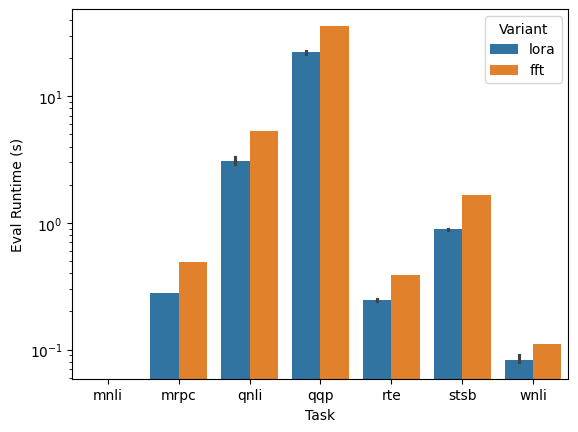

In [30]:
sns.barplot(df, x='Task', y='Eval Runtime (s)', hue='Variant')
plt.yscale('log')

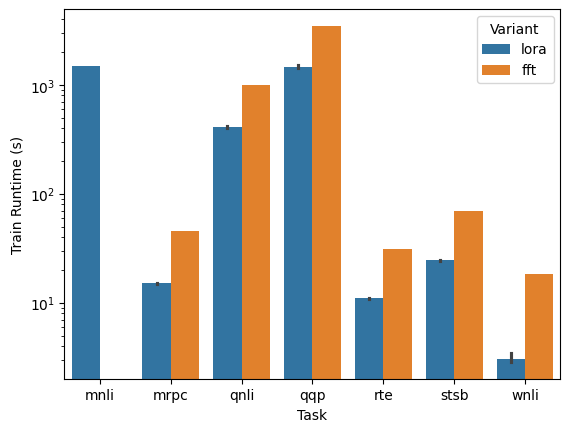

In [31]:
sns.barplot(df, x='Task', y='Train Runtime (s)', hue='Variant')
plt.yscale('log')

In [32]:
data = json.loads(Path('results/lora/task_mnli_bert_42/base_32_5e-05_0.01/peft_lora_16_0.05_8/metrics.json').read_text())

In [34]:
dictor(data, 'args.task')

'mnli'